# Clase 2
[notebook](https://campus.exactas.uba.ar/mod/url/view.php?id=224044) original en Campus.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.linalg import inv

# Ejercicio 1

Reproduzca la figura 4.2 del libro *ISLR*:

*  Estime la probabilidad de `default` mediante un modelo lineal basado en variable `balance`. 
*  Grafique la probabilidad estimada en función de `balance` junto con las observaciones de la muestra.
*  Repita el gráfico para un modelo logístico.

**Sugerencia:** considere el comando `glm` con el argumento `family="binomial"`. ¿Qué significa `family="gaussian"`?

### Solución

In [2]:
default = pd.read_csv("../data/default.csv")

In [3]:
X = np.column_stack([
    np.repeat(1, len(default)),
    default.balance,
])
y = np.where(default.default == "Yes", 1, 0)

In [4]:
lin_model = sm.GLM(y, X, family=sm.families.Gaussian())
lin_fit = lin_model.fit()
print(lin_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                        0.028251
Method:                          IRLS   Log-Likelihood:                 3644.8
Date:                Wed, 01 Dec 2021   Deviance:                       282.45
Time:                        12:16:54   Pearson chi2:                     282.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1304
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0752      0.003    -22.416      0.0

In [5]:
log_model = sm.GLM(y, X, family=sm.families.Binomial())
log_fit = log_model.fit()
print(log_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -798.23
Date:                Wed, 01 Dec 2021   Deviance:                       1596.5
Time:                        12:16:55   Pearson chi2:                 7.15e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1240
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.6513      0.361    -29.491      0.0

In [6]:
grid_size = 1000
grid = np.column_stack([
    np.repeat(1, grid_size),
    np.linspace(0, default.balance.max(), grid_size)
])

In [7]:
lin_pred = lin_fit.predict(grid)
log_pred = log_fit.predict(grid)

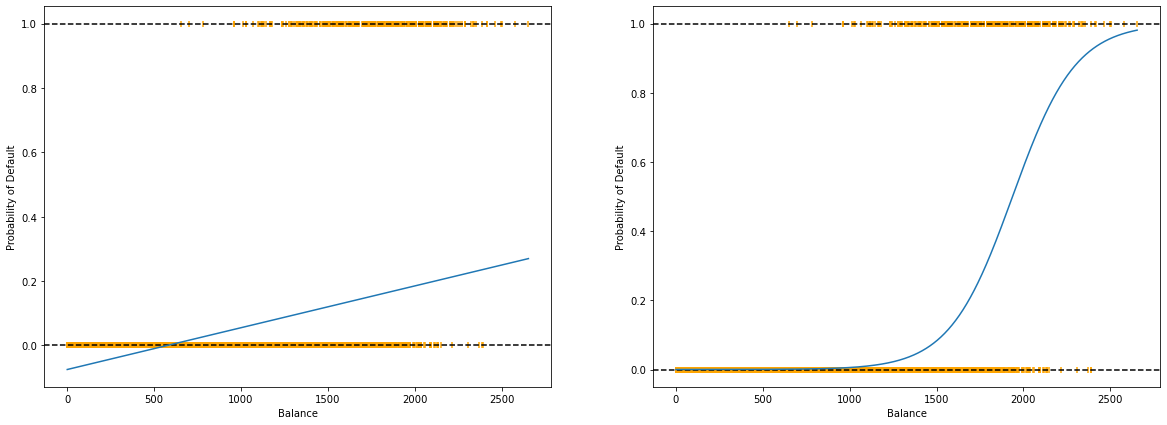

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))
for ax, pred in zip(axs, [lin_pred, log_pred]):
    [ax.axhline(y, linestyle="dashed", color="black") for y in (0, 1)]
    ax.scatter(default.balance, y, marker="|", color="orange")
    ax.set_xlabel("Balance")
    ax.set_ylabel("Probability of Default")
    ax.plot(grid[:, 1], pred)
plt.show()

# Ejercicio 2

* Implemente una función que realice una regresión logística múltiple, para el caso de dos clases, y devuelva los coeficientes estimados y las probabilidades estimadas. 
* Compare con la salida del comando `glm` usando las *features* `balance` e `income`.
* (*) Agregue a su función los errores estándar e intervalos de confianza para los parámetros (compare con la salida del comando `confint`)

**Sugerencias:** 
* considere el comando `optim` para maximizar la función de verosimilitud,
* tenga cuidado con la escala de las variables,
* vincule la varianza asintótica del estimador de máxima verosimilitud con el argumento `hessian` del comando `optim`.


### Solución
El ejercicio siguiente pide modelar también una regresión Poisson, así que en aras de la generalidad que nadie pidió, a continuación implementé una clase "de juguete", que resuelve por método de máxima verosimilitud la estimación de los parámetros de un Modlo Lineal Generalizado de tipo Gaussiano (lineal), Binomial (de n=1, es decir logístico o de Bernoulli) y Poisson.

Es realmente difícil - prácticamente imposible - implementar algoritmos que sin manipular los datos iniciales para llevarlos a escalas razonables, ni explotar inteligentemente las propiedades de distintas funciones de pérdida,
- no se topen con "overflows" (valores más grandes de los que el computador puede representar) durante la minimización, ni que
- tarden una cantidad razonable de tiempo.

Por eso, aunque uno podría definir una función de log-verosimilitud (`loglikelihood`) genérica como 
```python
sum([logpdf(y, theta) for y, theta in zip(y, X @ beta)])
```
, elegimos definir a mano una función que se lleve bien con `scipy.optimize.minimize` (el equivalente casi-literal en Python de `optim` en R). También convendría calcular el jacobiano o el hessiano y pasárselos a `minimize` como `jac` y `hess`, para mejorar la convergnecia, pero eso quedará como ejercicio para el lector.

In [51]:
from scipy.stats import norm, binom, poisson, bernoulli

def np_exp(x):
    """Use 128bits floats to avoid overflows when computing logloss"""
    return np.exp(x, dtype=np.float128)

def identity(x):
    return x

def logistic(x):
    return np_exp(x) / (1 + np_exp(x))

class GLM():
    
    LINKS = {"gaussian": identity, "bernoulli": logistic, "poisson": np_exp}
    
    def __init__(self, X, y, family="gaussian"):
        if family not in self.LINKS.keys():
            raise ValueError(f"{family} is not a recognised family. Try one of {list(self.LINKS)}")
        self.X = X
        self.y = y
        self.family = family
        self.link = self.LINKS[family]
        
    def loglikelihood(self, beta):
        theta = self.X @ beta  # `@` is the internal product <X, beta>
        # These are calculated by hand, and each representes the part of the log-likelihood function
        # than is affected by the choice of coefficients `beta` (via theta)
        if self.family == "gaussian":
            return - sum((self.y - theta) ** 2)
        elif self.family == "bernoulli":
            return sum(- np.log(1 + np_exp(theta)) + self.y * theta)
        elif self.family == "poisson":
            return sum(self.y * theta - np_exp(theta))
        else:
            raise NotImplementedError
        
    def fit(self):
        self.res_ = minimize(
            fun=lambda beta: -self.loglikelihood(beta),
            x0=np.zeros(self.X.shape[1]),
        )
        self.coefs_ = self.res_.x
        self.coefs_sd_ = np.diag(self.res_.hess_inv) ** .5
        self.y_ = self.predict()


    def predict(self, X=None):
        X = X if X is not None else self.X  # predict on the original data if there's no new data
        return self.link(X @ self.coefs_)
    
    def confint(self, p):
        """Return 100 * p % confidence interval for `coefs` """
        phi = norm.ppf((1 - p) /2)
        return [
            (c + phi * sd, c - phi * sd)
            for c, sd in zip (self.coefs_, self.coefs_sd_)
        ]

Construyo una matriz de diseño que responda a la fórmula $default \sim 1 + balance + income$

In [65]:
X = np.column_stack([
#     np.repeat(1, len(default)),
    default.balance,
    default.income,
])

Si así lo deseo, puedo armar un vector booleano (AKA `logical` en R) de `idxs`, y sólo fitear el modelo con ciertas observaciones

In [66]:
# idxs = np.random.choice(range(len(y)), 10000, replace=False)
idxs = np.arange(len(y))

In [67]:
my_model = GLM(X[idxs,], y[idxs], "bernoulli")
my_model.fit()

In [68]:
my_model.coefs_, my_model.coefs_sd_, my_model.confint(0.95)

(array([ 0.00040795, -0.0001259 ]),
 array([7.10314375e-05, 3.73577800e-06]),
 [(0.00026872704012164984, 0.0005471651587936552),
  (-0.00013322682278532272, -0.00011858284210744798)])

In [69]:
sm_model = sm.GLM(y[idxs], X[idxs], family=sm.families.Binomial())
sm_fit = sm_model.fit()
print(sm_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1734.6
Date:                Wed, 01 Dec 2021   Deviance:                       3469.1
Time:                        12:24:48   Pearson chi2:                 3.87e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           -0.05638
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0004   7.03e-05      5.797      0.0

In [74]:
def mse(x1, x2):
    """Calcula el error cuadrático medio."""
    return ((x1 - x2)**2).mean()

In [79]:
sm_pred = sm_fit.predict()
my_pred = my_model.predict()
pd.Series({
    "mse(y, sm_pred)": mse(y, sm_pred),
    "mse(y, my_pred)": mse(y, my_pred),
    "mse(my_pred, sm_pred)": mse(my_pred, sm_pred),
}).round(6)

mse(y, sm_pred)          0.036675
mse(y, my_pred)          0.036674
mse(my_pred, sm_pred)    0.000000
dtype: float128

In [88]:
assert np.allclose(my_pred, sm_pred, rtol=1.5e-3)

Las predicciones de nuestra implementación casera son igual de certeras que las de `statsmodels`, y además, parecen ser casi idénticas, con una diferencia máxima del $0.15\%$.

In [71]:
my_model.predict().mean(), my_model.predict(X).mean()

(0.057188775778832085228, 0.057188775778832085228)

In [72]:
y.mean()

0.0333

In [16]:
my_model.coefs_, sm_fit.params

(array([-1.15382472e+01,  5.64661729e-03,  2.07675178e-05]),
 array([-1.15404684e+01,  5.64710295e-03,  2.08089755e-05]))

In [17]:
assert np.allclose(my_model.coefs_, sm_fit.params, rtol=1e-2)

In [18]:
np.diag(sm_fit.cov_params()) ** .5, my_model.coefs_sd_

(array([4.34772469e-01, 2.27381384e-04, 4.98524546e-06]),
 array([4.61975619e-01, 2.37636776e-04, 5.32899951e-06]))

Nuestra implementación casera de regresión binomial coincide con la de `statsmodels` a una diferencia relativa menor al 1%! Regocijemosnos, hermanos, porque _funciona_. La varianza estimada tiene algunas diferencias más importantes, pero todavía muy menores al 10%, lo cual también es tranquilizador.

In [19]:
my_model = GLM(X[idxs,], y[idxs], "gaussian")
my_model.fit()

In [20]:
sm_model = sm.GLM(y[idxs], X[idxs], family=sm.families.Gaussian())
sm_fit = sm_model.fit()
print(sm_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                        0.028217
Method:                          IRLS   Log-Likelihood:                 3651.3
Date:                Wed, 01 Dec 2021   Deviance:                       282.08
Time:                        12:17:33   Pearson chi2:                     282.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1316
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0922      0.006    -15.936      0.0

In [21]:
my_model.coefs_, sm_fit.params

(array([-9.01427361e-02,  1.31540414e-04,  4.04486368e-07]),
 array([-9.22396837e-02,  1.31804970e-04,  4.60456800e-07]))

In [22]:
assert np.allclose(my_model.coefs_, sm_fit.params, rtol=1e-1)

In [23]:
my_model.coefs_sd_ / np.diag(sm_fit.cov_params()) ** .5 

array([4.20951675, 4.20951597, 4.20951819])

La regresión lineal también encuentra los mismos coeficientes para el modelo, pero el desvío estándar calculado está mal por un factor de 4.2. Habría que revisar por qué.

## Ejercicio de fin de clase
1. Modelar una Regresión lineal para el dataset Bikeshare.
2. Modelar una Regresión Poisson para el dataset Bikeshare.
3. Comparar los resultados obtenidos entre los dos modelos.

In [93]:
bike = pd.read_csv("../data/bikeshare.csv")

Elegimos una matriz de diseño medio al azar para probar el método.

<AxesSubplot:xlabel='hr'>

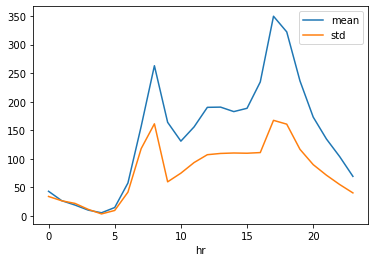

In [127]:
_bike = bike.groupby("hr").bikers.agg([np.mean, np.std])
_bike.plot()#(np.cov)

In [134]:
np.corrcoef(_bike["mean"], _bike["std"])

array([[1.        , 0.96852111],
       [0.96852111, 1.        ]])

La media de `bikers` por hora del día varía de manera casi idéntica (con un coeficiente de correlación de Pearson del 0.96) al desvío estándar de `bikers` for hora, así que un modelo $Poisson(\lambda)$, con $\mu = \sigma = \lambda$, pareciera adecuado.

In [135]:
X = np.column_stack([
    np.repeat(1, len(bike)),
    bike.weekday,
    bike.hr,
    bike.temp,
])
y = bike.bikers

In [136]:
# idxs = np.random.choice(range(len(y)), 10000, replace=False)
idxs = np.arange(len(y))

In [143]:
my_model = GLM(X, y, "poisson")
my_model.fit()

In [144]:
my_model.coefs_, my_model.coefs_sd_, my_model.confint(0.95)

(array([3.21425253, 0.00644106, 0.05221665, 1.99433096]),
 array([0.00366894, 0.00043548, 0.000136  , 0.00474422]),
 [(3.20706154310758, 3.221443520225647),
  (0.005587532907482795, 0.007294588662821566),
  (0.05195008283318116, 0.052483208142523705),
  (1.9850324563090251, 2.003629465145264)])

In [145]:
sm_model = sm.GLM(y, X, family=sm.families.Poisson())
sm_fit = sm_model.fit()
print(sm_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 bikers   No. Observations:                 8645
Model:                            GLM   Df Residuals:                     8641
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.6975e+05
Date:                Sat, 20 Nov 2021   Deviance:                   6.8646e+05
Time:                        01:01:23   Pearson chi2:                 7.45e+05
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2143      0.004    878.552      0.0

In [146]:
my_model.coefs_, sm_fit.params.values

(array([3.21425253, 0.00644106, 0.05221665, 1.99433096]),
 array([3.21425197, 0.00644108, 0.05221669, 1.99433081]))

In [141]:
assert np.allclose(my_model.coefs_, sm_fit.params, rtol=1e-5)

In [142]:
assert np.allclose(my_model.coefs_sd_, np.diag(sm_fit.cov_params()) ** .5 , rtol=1e-1)

Para el MLG de familia Poisson, los coeficientes calculados por EMV coinciden al $0.001\%$ con los de `statsmodels`, y hasta la varianza estimada da un error menor al 10%, ¡nada mal!

In [149]:
poisson_pred = sm.GLM(y, X, family=sm.families.Poisson()).fit().predict(X)
gaussian_pred = sm.GLM(y, X).fit().predict(X)  # Gaussiana es la familia por default de `sm.GLM`

In [154]:
mse(y, poisson_pred), mse(y, gaussian_pred)

(12493.660113577993, 109.48678067208304)

Así brutamente comparadas por ECM, las predicciones de ambos modelos parecen de similar (pésima) calidad. Habría que trabajar en la fórmula del modelo, considerar más variables, realizar algún tipo de validación cruzada y otras tantas yerbas para llevarlo a un lugar razonable.